<a href="https://colab.research.google.com/github/hectormelo/Machine-Learning-Techniques/blob/main/Taller_2/Taller_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024

## Integrantes

*   Julian Mora.
*   Miguel Zapata.



# **Taller 2**

GeoAlpes, una empresa líder en análisis geoespacial, está buscando mejorar sus técnicas de clasificación automática de imágenes satelitales. El objetivo es poder categorizar distintas características geográficas (como bosques, zonas industriales, zonas de cultivos permanentes, zonas residenciales y rios) con alta precisión y rapidez. Para lograrlo, están interesados en explorar las capacidades de los métodos ensemble.

1.  Exploración y Preparación de Datos

    -   Discuta las particularidades de las imágenes satelitales y sugiera técnicas extra de preprocesamiento de ser necesario.

2.  Implementación de Gradient Boosting

    -   Utilice Gradient Boosting como modelo base. Discuta las ventajas y desafíos de este método, y cómo afecta la precisión y robustez del clasificador. Además, compare el desempeño de Gradient Boosting con el modelo Random Forest presentado en la práctica, ¿logra observar mejoras significativas?

3. Implementación de un nuevo metodo Ensemble
    - Elija y presente un método ensemble de su preferencia.Introduzca y discuta el concepto del método elegido y cómo podría ser benéfico para la clasificación de imágenes satelitales.
    - Compare el desempeño de su método elegido con Gradient Boosting y el modelo Random Forest. Discuta las ventajas y desventajas de cada uno.

4.  Optimización y Ajuste

    -   Realice una búsqueda de los mejores hiperparámetros para mejorar el desempeño de cada uno de los modelos implementados (Grid Search).

Datos: [Enlace al sub conjunto del dataset de imágenes satelitales EuroSAT](https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip)


# 0. Importación de Librerías

In [4]:
import os
import time

import numpy as np

import matplotlib.pyplot as plt

import cv2
import requests

from sklearn.metrics import accuracy_score # Cálculo de la precisión
from sklearn.decomposition import PCA # Análisis de componentes principales
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Matriz de confusión
from sklearn.model_selection import train_test_split # División de datos en entrenamiento y prueba
from sklearn.model_selection import GridSearchCV # Búsqueda de hiperparámetros
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler # Estandarización de datos

from sklearn.metrics import classification_report, accuracy_score # Reporte de clasificación y precisión
from sklearn.svm import SVC # Máquina de soporte vectorial
from sklearn.ensemble import RandomForestClassifier #Librería para manejo del algoritmo Random Forest

from PIL import Image #Librería para brir, manipular y guardar muchos formatos diferentes de archivos de imágenes.

from skimage import io
from zipfile import ZipFile
from io import BytesIO

## 1. Exploración de Datos

In [5]:
# Descargar dataset
url = 'https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip'

# Descargar el archivo ZIP
response = requests.get(url)
zip_content = response.content
# Descomprimir el contenido en memoria
with ZipFile(BytesIO(zip_content)) as zip_file:
    zip_file.extractall("/content/data/EuroSAT")  # Especifica el directorio donde quieres descomprimir
print("Archivo descomprimido.")

Archivo descomprimido.


In [6]:
# Carga de imágenes

def load_image(folder,width, height):
    img, y = [], []

    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels
            image = cv2.resize(image, (width, height))
            img.append(image)
            y.append(file)

    return np.array(img), np.array(y)

In [7]:
#Cargar las imágenes que se encuentran en EuroSAT
X, y = load_image('/content/data/EuroSAT', 32, 32)
#Partimos el conjunto de datos en un conjunto de entrenamiento (80%) y otro de test (20%)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(3750, 32, 32, 3)
(3750,)
0
['Forest' 'Industrial' 'PermanentCrop' 'Residential' 'River']


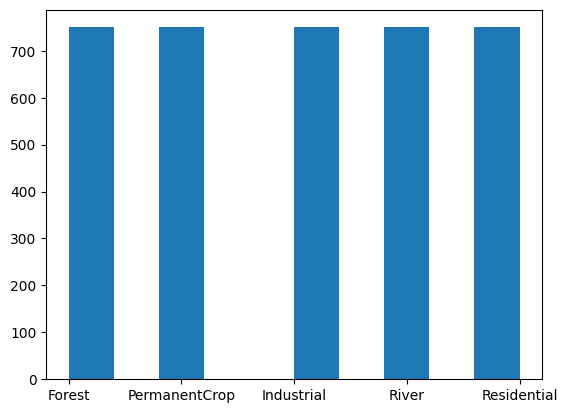

In [8]:
# Exploración de datos

print(X.shape) # 3750 imágenes de 64 x 64 pixéles y las dimensiones de RGB (3)
print(y.shape) # Las etiquetas correspondientes
print(np.isnan(X).sum()) # Los datos están completos
print(np.unique(y)) # Las imágenes están clasificadas en 5 categorías
plt.hist(y) # Las categorías están balanceadas y presentan una distribución uniforme
plt.show()

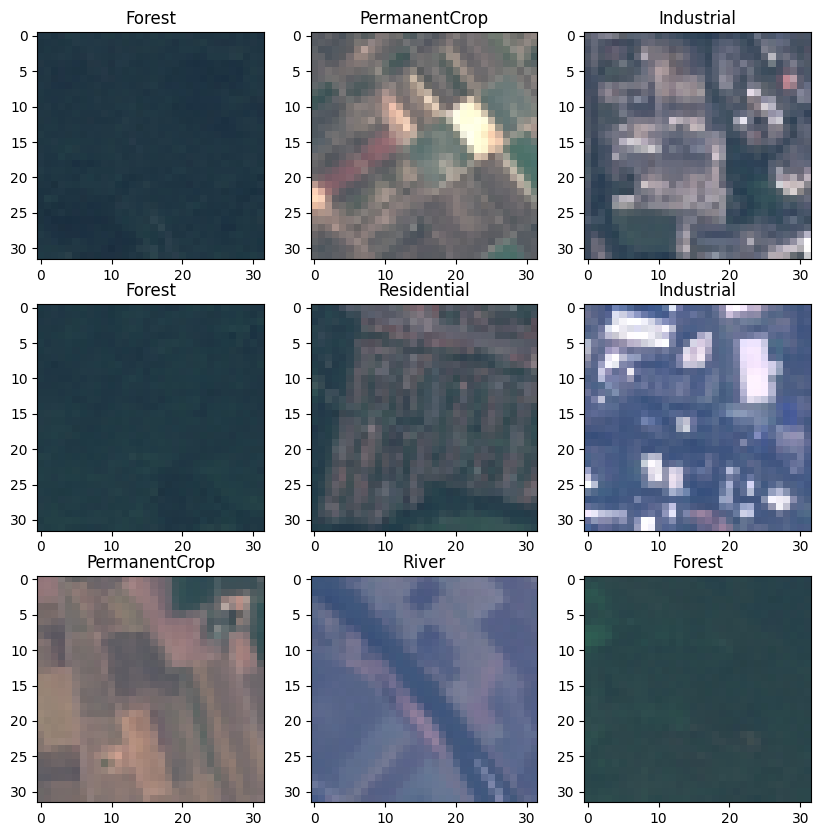

In [9]:
np.random.seed(24) # Para hacer los resultados reproducibles

# Observar las imágenes
plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(X))
    plt.imshow(X[rdn])
    plt.title(y[rdn])

In [10]:
# Observar la distribución de los labels
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
# Para imprimir cada par clave-valor en una línea nueva de los valores de entrenaimento
print("Distribución de los labels de entrenamiento: ")
dic_entrenamiento=  dict(zip(unique_train, counts_train))
for clave, valor in dic_entrenamiento.items():
    print(f'{clave}: {valor}')
# Para imprimir cada par clave-valor en una línea nueva de los valores de test
print("\nDistribución de los labels de test: ")
dic_test= dict(zip(unique_test, counts_test))
for clave, valor in dic_test.items():
    print(f'{clave}: {valor}')

Distribución de los labels de entrenamiento: 
Forest: 581
Industrial: 605
PermanentCrop: 601
Residential: 610
River: 603

Distribución de los labels de test: 
Forest: 169
Industrial: 145
PermanentCrop: 149
Residential: 140
River: 147


# 2. Preparación de datos

In [11]:
# Convertir imágenes a vectores 1D
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# Estandarización
scaler = StandardScaler().fit(x_train_reshaped)
x_train_standard = scaler.transform(x_train_reshaped)
x_test_standard = scaler.transform(x_test_reshaped)


In [12]:
# Aplicar PCA para reducir la dimensionalidad conservando el 95% de la varianza
pca = PCA(0.95).fit(x_train_standard)
x_train_pca = pca.transform(x_train_standard)
x_test_pca = pca.transform(x_test_standard)

In [13]:
# Transformador para pasar de 3D (64x64x3) a 1D (12288)
# Lo utilizamos porque el modelo de Gradient Boosting tiene como input un vector de carácteristicas para
# cada observación. En contraste a una red convolusional que si maneja la matriz como tal.
flatenner = FunctionTransformer(lambda m: m.reshape(m.shape[0], -1))

# Pipeline para hacer el preprocesamiento de datos robusto y reproducible
# Usamos StandardScaler para mejorar el resultado de PCA, ya que es sensible a la escala de los datos
# Usamos PCA para reducir la dimensionalidad (menor a 12288) explicando el 95% de la varianza observada
# Mejorando el tiempo de entrenamiento del modelo
pipeline = Pipeline([
    ('flatenner', flatenner),
    ('standardscaler', StandardScaler()),
    ('pca', PCA(0.95))
])
pipeline

Pipeline(steps=[('flatenner',
                 FunctionTransformer(func=<function <lambda> at 0x7ab0882ca4d0>)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95))])

In [14]:
# Aplicar el pipeline a los datos de entrenamiento y de prueba
x_train_processed = pipeline.fit_transform(x_train)
x_test_processed = pipeline.transform(x_test)

## Implementación de Gradient Boosting

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# Crear un clasificador de Gradient Boosting
clasificador_gb = GradientBoostingClassifier(random_state=0)

In [16]:
# Entrenar el clasificador con los datos de entrenamiento procesados
clasificador_gb.fit(x_train_processed, y_train)


GradientBoostingClassifier(random_state=0)

In [17]:
# Realizar predicciones en los datos de prueba procesados
y_pred_gb = clasificador_gb.predict(x_test_processed)

In [18]:
# Evaluar el desempeño del modelo
precision_gb = accuracy_score(y_test, y_pred_gb)
print("Precisión de Gradient Boosting:", precision_gb)


Precisión de Gradient Boosting: 0.8306666666666667


In [19]:
# Informe de clasificación
print("\nInforme de clasificación de Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))


Informe de clasificación de Gradient Boosting:
               precision    recall  f1-score   support

       Forest       0.95      0.99      0.97       169
   Industrial       0.91      0.86      0.88       145
PermanentCrop       0.75      0.72      0.74       149
  Residential       0.72      0.79      0.76       140
        River       0.81      0.77      0.79       147

     accuracy                           0.83       750
    macro avg       0.83      0.83      0.83       750
 weighted avg       0.83      0.83      0.83       750




Matriz de confusión de Gradient Boosting:


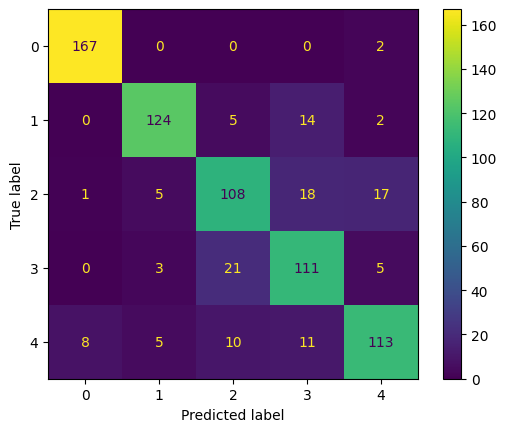

In [20]:
# Matriz de confusión
print("\nMatriz de confusión de Gradient Boosting:")
cm_gb = confusion_matrix(y_test, y_pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
disp_gb.plot()


# 3. Random Forest

### 3.1. Prueba 1 - 100 árboles

In [21]:
# Crear un clasificador de Random Forest
# Este modelo trabaja con 100 árboles. Vamos a realizar este modelo como prueba y después variaremos la cantidad de árboles y la profundidad
clasificador_rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)

In [22]:
# Entrenar el clasificador con los datos de entrenamiento
# Entrenamiento y creación del modelo
start = time.time()
clasificador_rf.fit(x_train_pca, y_train)
# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento: {end - start}")

Tiempo de entrenamiento: 7.420155763626099


In [23]:
# Realizar predicciones en los datos de prueba
y_pred_rf = clasificador_rf.predict(x_test_pca)

Precisión de Random Forest: 0.8013333333333333

Informe de clasificación de Random Forest:
               precision    recall  f1-score   support

       Forest       0.98      0.97      0.97       169
   Industrial       0.84      0.91      0.87       145
PermanentCrop       0.70      0.70      0.70       149
  Residential       0.75      0.66      0.70       140
        River       0.71      0.74      0.73       147

     accuracy                           0.80       750
    macro avg       0.80      0.80      0.79       750
 weighted avg       0.80      0.80      0.80       750


Matriz de confusión de Random Forest:


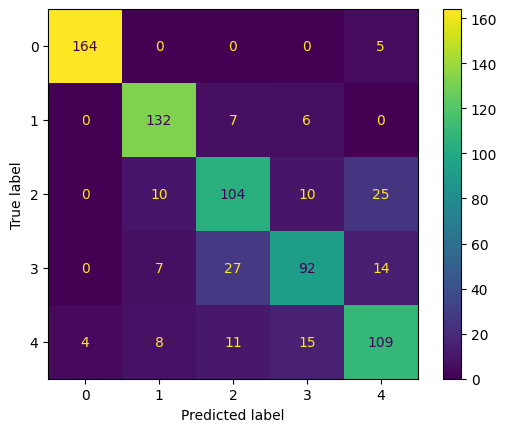

In [24]:

# Comparación de desempeño entre Random Forest y GridSearchCV

# Precisión
print("Precisión de Random Forest:", accuracy_score(y_test, y_pred_rf))

# Informe de clasificación
print("\nInforme de clasificación de Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Matriz de confusión
print("\nMatriz de confusión de Random Forest:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()

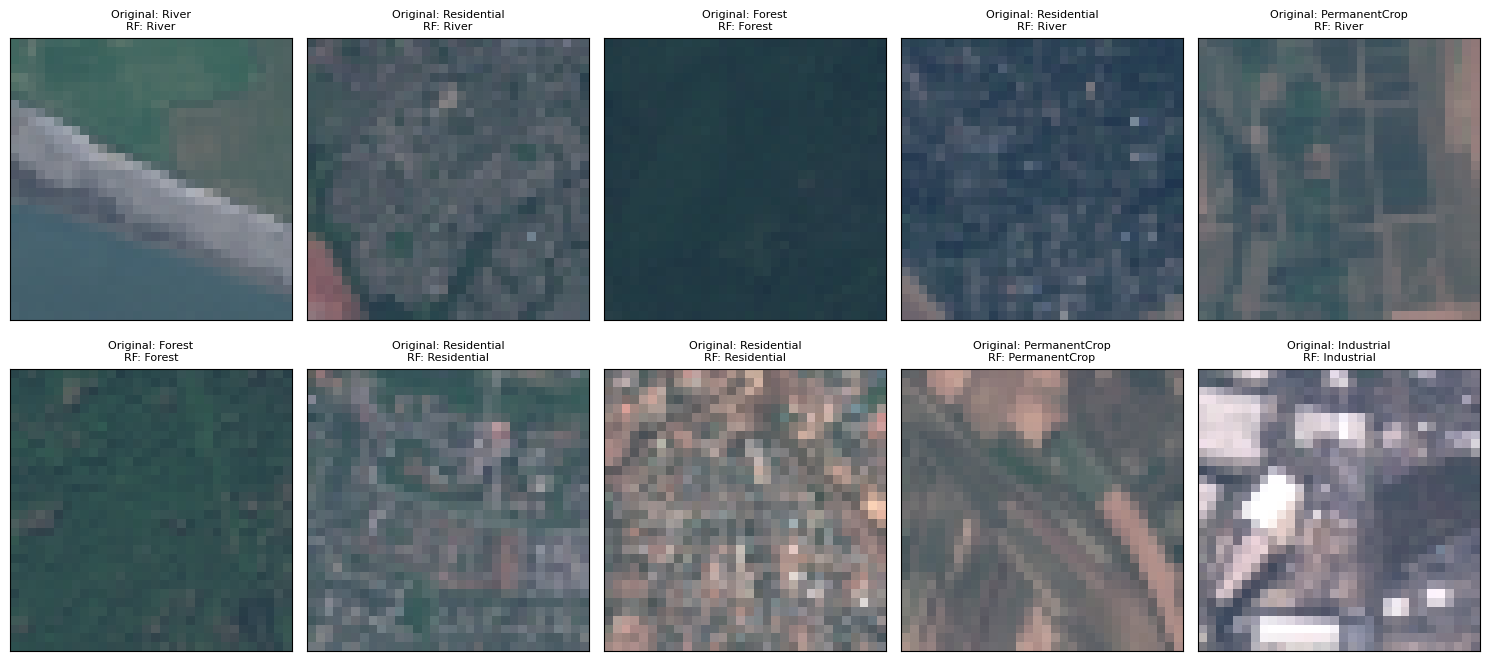

In [25]:
# Seleccionar 10 imágenes aleatorias
indices = np.random.choice(range(len(x_test)), size=10, replace=False)

# Crear una figura con 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Iterar sobre las 10 imágenes seleccionadas
for i, index in enumerate(indices):
    # Obtener la imagen y la etiqueta real
    image = x_test[index]
    true_label = y_test[index]

    # Predecir la etiqueta usando RandomForest
    predicted_label_rf = clasificador_rf.predict([x_test_pca[index]])

    # Mostrar la imagen
    axes[i // 5, i % 5].imshow(image, cmap='gray')
    # Establecer el título con la etiqueta original, la predicción de SVM y la predicción de Random Forest
    axes[i // 5, i % 5].set_title(f"Original: {true_label}\nRF: {predicted_label_rf[0]}", fontsize=8)
    axes[i // 5, i % 5].set_xticks([])
    axes[i // 5, i % 5].set_yticks([])

# Mostrar la figura
plt.tight_layout()
plt.show()

### 3.2. Prueba 2 - 100 árboles y profundidad máxima 2


Tiempo de entrenamiento (100 árboles, profundidad 2): 2.6816039085388184
Precisión de Random Forest (100 árboles, profundidad 2): 0.696

Informe de clasificación de Random Forest (100 árboles, profundidad 2):
               precision    recall  f1-score   support

       Forest       0.79      1.00      0.88       169
   Industrial       0.72      0.91      0.80       145
PermanentCrop       0.72      0.62      0.66       149
  Residential       0.52      0.65      0.58       140
        River       0.73      0.26      0.38       147

     accuracy                           0.70       750
    macro avg       0.70      0.69      0.66       750
 weighted avg       0.70      0.70      0.67       750


Matriz de confusión de Random Forest (100 árboles, profundidad 2):


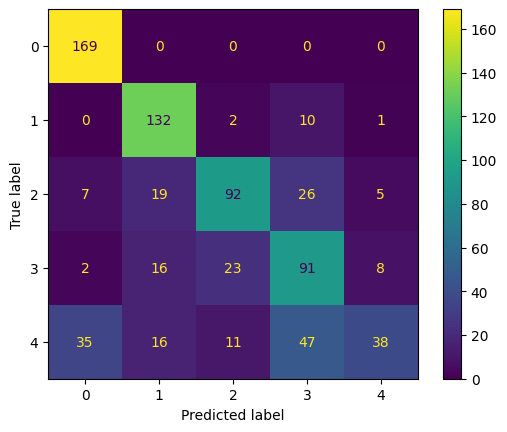

In [26]:
# Crear un clasificador de Random Forest con 100 árboles y profundidad máxima de 2
clasificador_rf_100_2 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=2, random_state=0)

# Entrenar el clasificador con los datos de entrenamiento
start = time.time()
clasificador_rf_100_2.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento (100 árboles, profundidad 2): {end - start}")

# Realizar predicciones en los datos de prueba
y_pred_rf_100_2 = clasificador_rf_100_2.predict(x_test_pca)

# Comparación de desempeño
precision_rf_100_2 = accuracy_score(y_test, y_pred_rf_100_2)
print("Precisión de Random Forest (100 árboles, profundidad 2):", precision_rf_100_2)

# Informe de clasificación
print("\nInforme de clasificación de Random Forest (100 árboles, profundidad 2):")
print(classification_report(y_test, y_pred_rf_100_2))

# Matriz de confusión
print("\nMatriz de confusión de Random Forest (100 árboles, profundidad 2):")
cm_rf_100_2 = confusion_matrix(y_test, y_pred_rf_100_2)
disp_rf_100_2 = ConfusionMatrixDisplay(confusion_matrix=cm_rf_100_2)
disp_rf_100_2.plot()

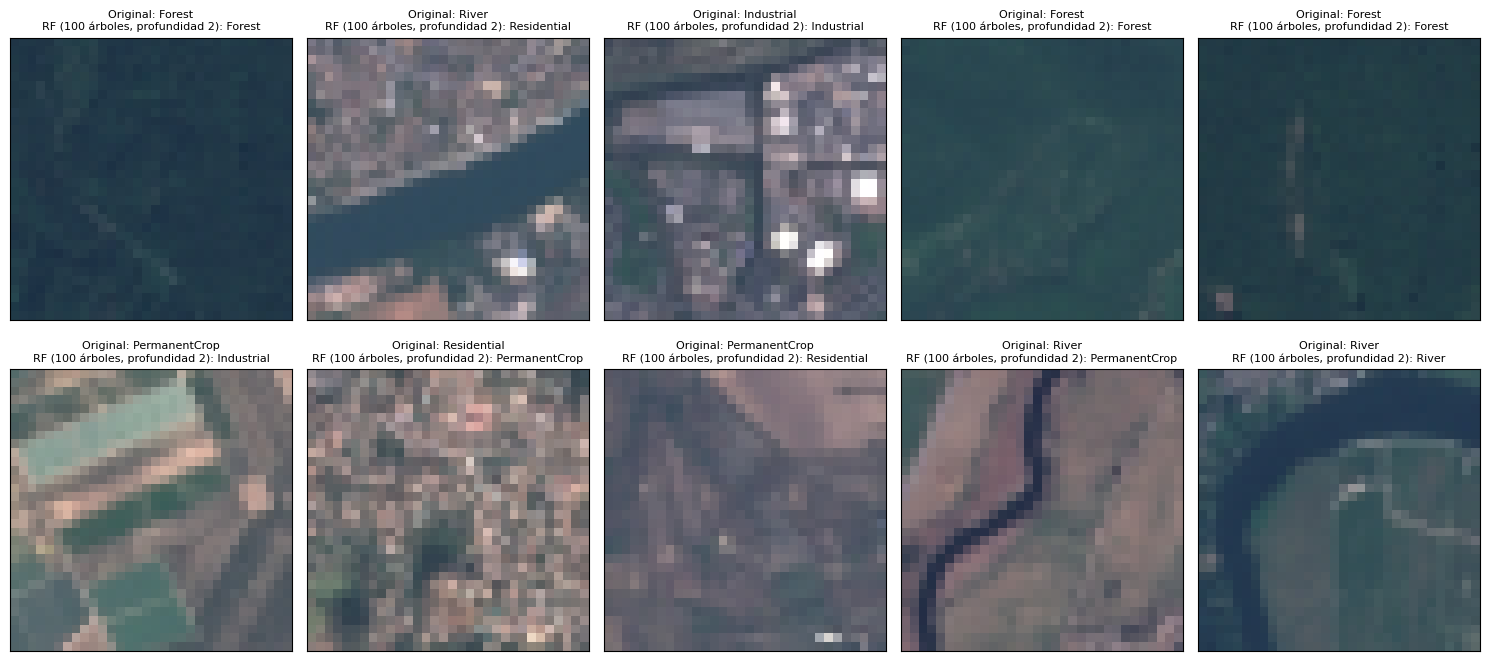

In [27]:
# Seleccionar 10 imágenes aleatorias
indices = np.random.choice(range(len(x_test)), size=10, replace=False)

# Crear una figura con 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Iterar sobre las 10 imágenes seleccionadas
for i, index in enumerate(indices):
    # Obtener la imagen y la etiqueta real
    image = x_test[index]
    true_label = y_test[index]

    # Predecir la etiqueta usando RandomForest con 100 árboles y profundidad 2
    predicted_label_rf_100_2 = clasificador_rf_100_2.predict([x_test_pca[index]])

    # Mostrar la imagen
    axes[i // 5, i % 5].imshow(image, cmap='gray')
    # Establecer el título con la etiqueta original y la predicción de Random Forest (100 árboles, profundidad 2)
    axes[i // 5, i % 5].set_title(f"Original: {true_label}\nRF (100 árboles, profundidad 2): {predicted_label_rf_100_2[0]}", fontsize=8)
    axes[i // 5, i % 5].set_xticks([])
    axes[i // 5, i % 5].set_yticks([])

# Mostrar la figura
plt.tight_layout()
plt.show()


### 3.3. Prueba 3 - 100 árboles y profundidad máxima de 3

Tiempo de entrenamiento (100 árboles, profundidad 3): 2.4980976581573486
Precisión de Random Forest (100 árboles, profundidad 3): 0.7386666666666667

Informe de clasificación de Random Forest (100 árboles, profundidad 3):
               precision    recall  f1-score   support

       Forest       0.83      1.00      0.91       169
   Industrial       0.74      0.92      0.82       145
PermanentCrop       0.74      0.63      0.68       149
  Residential       0.60      0.69      0.64       140
        River       0.77      0.41      0.53       147

     accuracy                           0.74       750
    macro avg       0.74      0.73      0.72       750
 weighted avg       0.74      0.74      0.72       750


Matriz de confusión de Random Forest (100 árboles, profundidad 3):


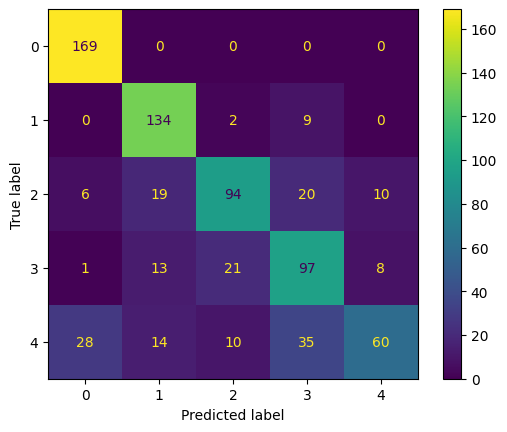

In [28]:
# Crear un clasificador de Random Forest con 100 árboles y profundidad máxima de 3
clasificador_rf_100_3 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=3, random_state=0)

# Entrenar el clasificador con los datos de entrenamiento
start = time.time()
clasificador_rf_100_3.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento (100 árboles, profundidad 3): {end - start}")

# Realizar predicciones en los datos de prueba
y_pred_rf_100_3 = clasificador_rf_100_3.predict(x_test_pca)

# Comparación de desempeño
precision_rf_100_3 = accuracy_score(y_test, y_pred_rf_100_3)
print("Precisión de Random Forest (100 árboles, profundidad 3):", precision_rf_100_3)

# Informe de clasificación
print("\nInforme de clasificación de Random Forest (100 árboles, profundidad 3):")
print(classification_report(y_test, y_pred_rf_100_3))

# Matriz de confusión
print("\nMatriz de confusión de Random Forest (100 árboles, profundidad 3):")
cm_rf_100_3 = confusion_matrix(y_test, y_pred_rf_100_3)
disp_rf_100_3 = ConfusionMatrixDisplay(confusion_matrix=cm_rf_100_3)
disp_rf_100_3.plot()

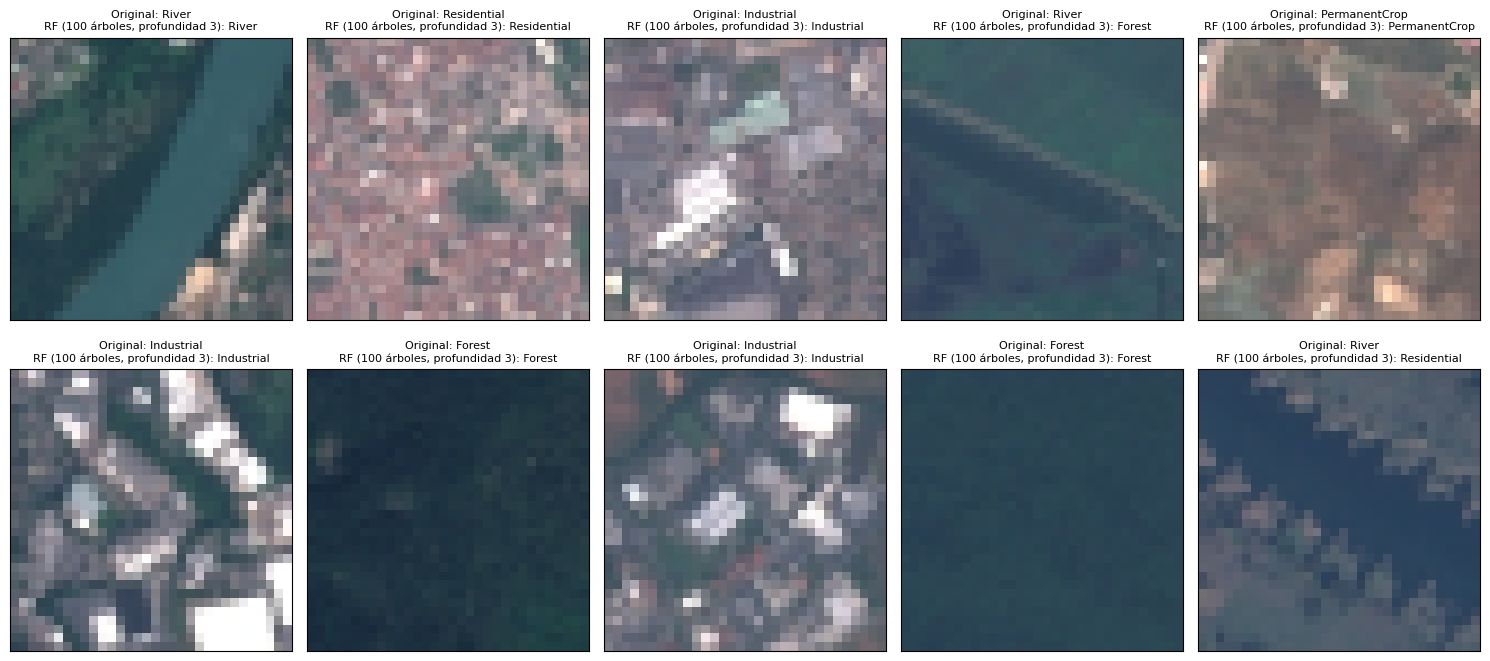

In [29]:
# Seleccionar 10 imágenes aleatorias
indices = np.random.choice(range(len(x_test)), size=10, replace=False)

# Crear una figura con 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Iterar sobre las 10 imágenes seleccionadas
for i, index in enumerate(indices):
    # Obtener la imagen y la etiqueta real
    image = x_test[index]
    true_label = y_test[index]

    # Predecir la etiqueta usando RandomForest con 100 árboles y profundidad 3
    predicted_label_rf_100_3 = clasificador_rf_100_3.predict([x_test_pca[index]])

    # Mostrar la imagen
    axes[i // 5, i % 5].imshow(image, cmap='gray')
    # Establecer el título con la etiqueta original y la predicción de Random Forest (100 árboles, profundidad 3)
    axes[i // 5, i % 5].set_title(f"Original: {true_label}\nRF (100 árboles, profundidad 3): {predicted_label_rf_100_3[0]}", fontsize=8)
    axes[i // 5, i % 5].set_xticks([])
    axes[i // 5, i % 5].set_yticks([])

# Mostrar la figura
plt.tight_layout()
plt.show()


### 3.4. Prueba 4 - 120 árboles y profundidad máxima 2

Tiempo de entrenamiento (120 árboles, profundidad 2): 2.1580944061279297
Precisión de Random Forest (120 árboles, profundidad 2): 0.7

Informe de clasificación de Random Forest (120 árboles, profundidad 2):
               precision    recall  f1-score   support

       Forest       0.79      1.00      0.88       169
   Industrial       0.73      0.90      0.80       145
PermanentCrop       0.74      0.62      0.67       149
  Residential       0.51      0.67      0.58       140
        River       0.77      0.27      0.40       147

     accuracy                           0.70       750
    macro avg       0.71      0.69      0.67       750
 weighted avg       0.71      0.70      0.68       750


Matriz de confusión de Random Forest (120 árboles, profundidad 2):


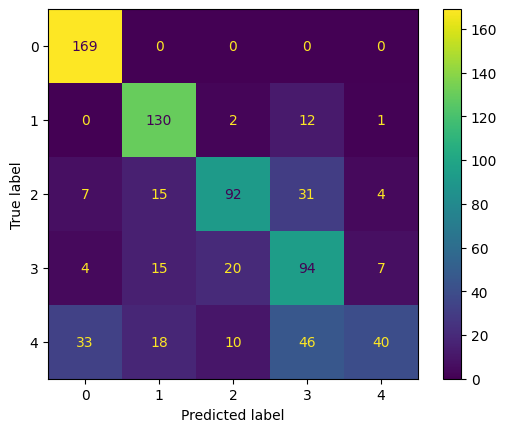

In [30]:
# Crear un clasificador de Random Forest con 120 árboles y profundidad máxima de 2
clasificador_rf_120_2 = RandomForestClassifier(n_estimators=120, criterion='entropy', max_depth=2, random_state=0)

# Entrenar el clasificador con los datos de entrenamiento
start = time.time()
clasificador_rf_120_2.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento (120 árboles, profundidad 2): {end - start}")

# Realizar predicciones en los datos de prueba
y_pred_rf_120_2 = clasificador_rf_120_2.predict(x_test_pca)

# Comparación de desempeño
precision_rf_120_2 = accuracy_score(y_test, y_pred_rf_120_2)
print("Precisión de Random Forest (120 árboles, profundidad 2):", precision_rf_120_2)

# Informe de clasificación
print("\nInforme de clasificación de Random Forest (120 árboles, profundidad 2):")
print(classification_report(y_test, y_pred_rf_120_2))

# Matriz de confusión
print("\nMatriz de confusión de Random Forest (120 árboles, profundidad 2):")
cm_rf_120_2 = confusion_matrix(y_test, y_pred_rf_120_2)
disp_rf_120_2 = ConfusionMatrixDisplay(confusion_matrix=cm_rf_120_2)
disp_rf_120_2.plot()


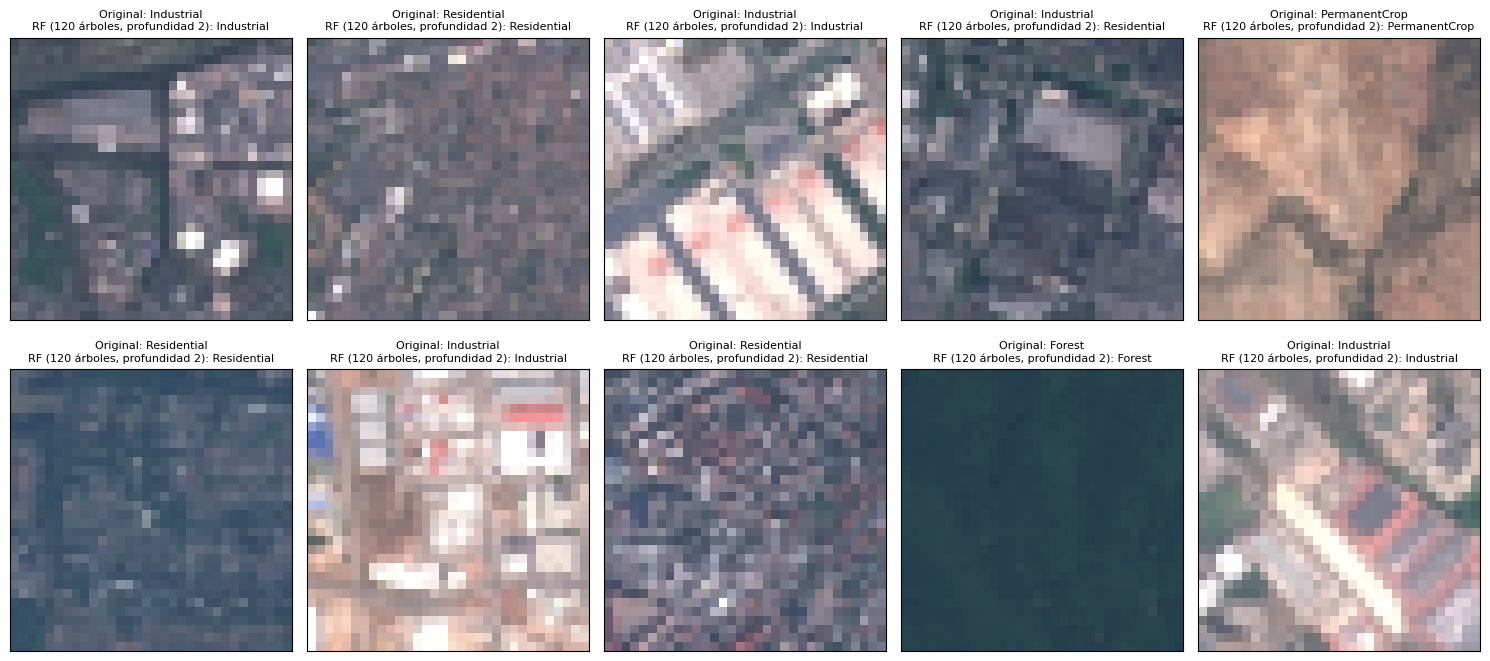

In [31]:
# Seleccionar 10 imágenes aleatorias
indices = np.random.choice(range(len(x_test)), size=10, replace=False)

# Crear una figura con 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Iterar sobre las 10 imágenes seleccionadas
for i, index in enumerate(indices):
    # Obtener la imagen y la etiqueta real
    image = x_test[index]
    true_label = y_test[index]

    # Predecir la etiqueta usando RandomForest con 120 árboles y profundidad 2
    predicted_label_rf_120_2 = clasificador_rf_120_2.predict([x_test_pca[index]])

    # Mostrar la imagen
    axes[i // 5, i % 5].imshow(image, cmap='gray')
    # Establecer el título con la etiqueta original y la predicción de Random Forest (120 árboles, profundidad 2)
    axes[i // 5, i % 5].set_title(f"Original: {true_label}\nRF (120 árboles, profundidad 2): {predicted_label_rf_120_2[0]}", fontsize=8)
    axes[i // 5, i % 5].set_xticks([])
    axes[i // 5, i % 5].set_yticks([])

# Mostrar la figura
plt.tight_layout()
plt.show()


### 3.5. Prueba 5 - 120 árboles y profundidad máxima 3


Tiempo de entrenamiento (120 árboles, profundidad 3): 3.5792675018310547
Precisión de Random Forest (120 árboles, profundidad 3): 0.744

Informe de clasificación de Random Forest (120 árboles, profundidad 3):
               precision    recall  f1-score   support

       Forest       0.83      1.00      0.91       169
   Industrial       0.77      0.92      0.84       145
PermanentCrop       0.76      0.66      0.71       149
  Residential       0.59      0.72      0.65       140
        River       0.76      0.37      0.50       147

     accuracy                           0.74       750
    macro avg       0.74      0.74      0.72       750
 weighted avg       0.75      0.74      0.73       750


Matriz de confusión de Random Forest (120 árboles, profundidad 3):


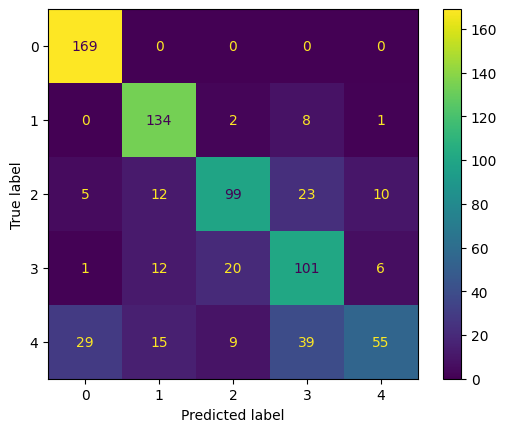

In [32]:
# Crear un clasificador de Random Forest con 120 árboles y profundidad máxima de 3
clasificador_rf_120_3 = RandomForestClassifier(n_estimators=120, criterion='entropy', max_depth=3, random_state=0)

# Entrenar el clasificador con los datos de entrenamiento
start = time.time()
clasificador_rf_120_3.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento (120 árboles, profundidad 3): {end - start}")

# Realizar predicciones en los datos de prueba
y_pred_rf_120_3 = clasificador_rf_120_3.predict(x_test_pca)

# Comparación de desempeño
precision_rf_120_3 = accuracy_score(y_test, y_pred_rf_120_3)
print("Precisión de Random Forest (120 árboles, profundidad 3):", precision_rf_120_3)

# Informe de clasificación
print("\nInforme de clasificación de Random Forest (120 árboles, profundidad 3):")
print(classification_report(y_test, y_pred_rf_120_3))

# Matriz de confusión
print("\nMatriz de confusión de Random Forest (120 árboles, profundidad 3):")
cm_rf_120_3 = confusion_matrix(y_test, y_pred_rf_120_3)
disp_rf_120_3 = ConfusionMatrixDisplay(confusion_matrix=cm_rf_120_3)
disp_rf_120_3.plot()


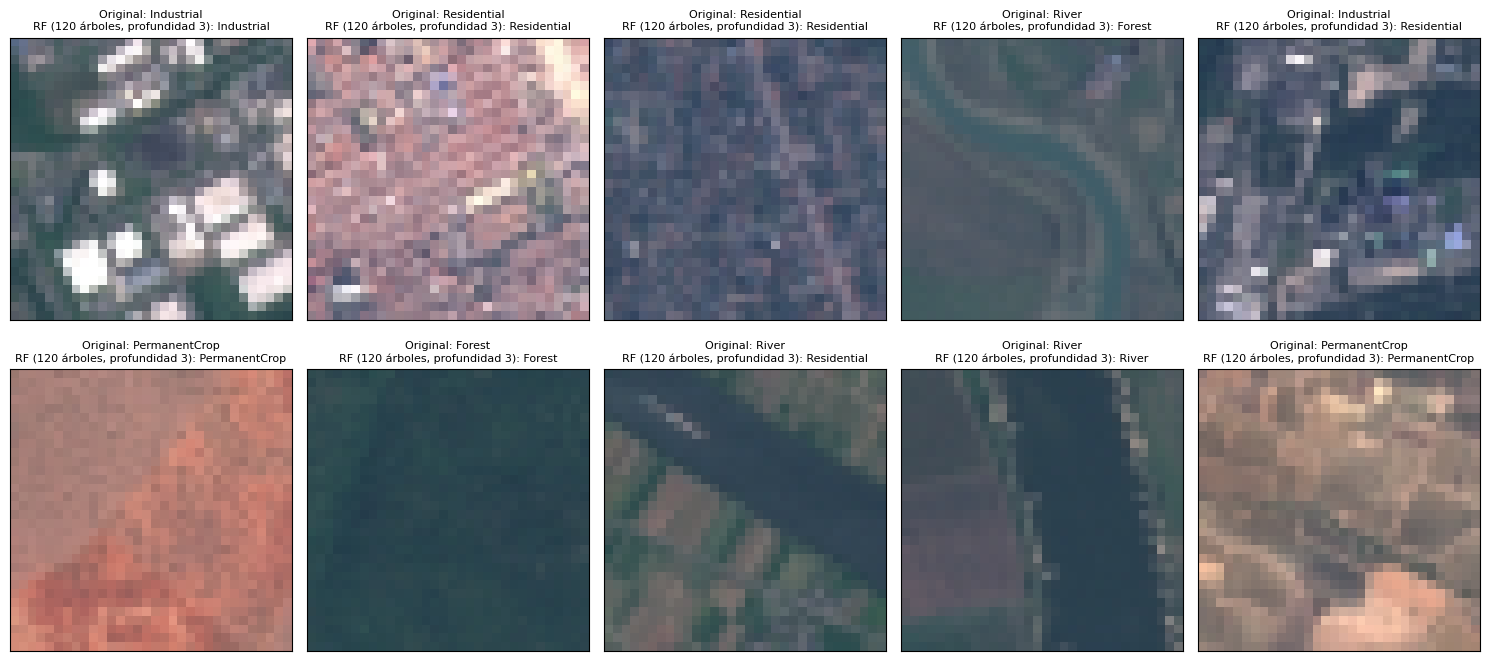

In [33]:
# Seleccionar 10 imágenes aleatorias
indices = np.random.choice(range(len(x_test)), size=10, replace=False)

# Crear una figura con 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Iterar sobre las 10 imágenes seleccionadas
for i, index in enumerate(indices):
    # Obtener la imagen y la etiqueta real
    image = x_test[index]
    true_label = y_test[index]

    # Predecir la etiqueta usando RandomForest con 120 árboles y profundidad 3
    predicted_label_rf_120_3 = clasificador_rf_120_3.predict([x_test_pca[index]])

    # Mostrar la imagen
    axes[i // 5, i % 5].imshow(image, cmap='gray')
    # Establecer el título con la etiqueta original y la predicción de Random Forest (120 árboles, profundidad 3)
    axes[i // 5, i % 5].set_title(f"Original: {true_label}\nRF (120 árboles, profundidad 3): {predicted_label_rf_120_3[0]}", fontsize=8)
    axes[i // 5, i % 5].set_xticks([])
    axes[i // 5, i % 5].set_yticks([])

# Mostrar la figura
plt.tight_layout()
plt.show()


# 4. Anális de resultados sobre Random Forest

La precisión del Random Forest con 100 árboles y profundidad máxima predeterminada es la más alta entre todas las pruebas realizadas, con una precisión de aproximadamente 0.8187.

Las pruebas con una profundidad máxima de 2 presentan una dismunición en la precisión del modelo, con respecto a la profundidad máxima de 3.

Aumentar el número de árboles a 120 no parece mejorar significativamente la precisión del modelo en comparación con 100 árboles.

Por lo tanto, vamos a realizar otras pruebas aumentando el número de árboles y aumentando la profundidad.

4.1. Prueba 6 - 200 árboles y profundidad máxima de 10

Tiempo de entrenamiento (200 árboles, profundidad 10): 13.798872947692871
Precisión de Random Forest (200 árboles, profundidad 10): 0.8133333333333334

Informe de clasificación de Random Forest (200 árboles, profundidad 10):
               precision    recall  f1-score   support

       Forest       0.98      0.99      0.98       169
   Industrial       0.82      0.90      0.86       145
PermanentCrop       0.72      0.68      0.70       149
  Residential       0.77      0.71      0.74       140
        River       0.75      0.76      0.75       147

     accuracy                           0.81       750
    macro avg       0.81      0.81      0.81       750
 weighted avg       0.81      0.81      0.81       750


Matriz de confusión de Random Forest (200 árboles, profundidad 10):


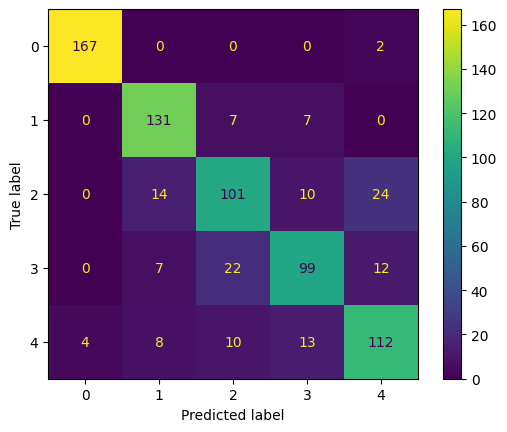

In [34]:
# Crear un clasificador de Random Forest con 200 árboles y profundidad máxima de 10
clasificador_rf_200_10 = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, random_state=0)

# Entrenar el clasificador con los datos de entrenamiento
start = time.time()
clasificador_rf_200_10.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento (200 árboles, profundidad 10): {end - start}")

# Realizar predicciones en los datos de prueba
y_pred_rf_200_10 = clasificador_rf_200_10.predict(x_test_pca)

# Comparación de desempeño
precision_rf_200_10 = accuracy_score(y_test, y_pred_rf_200_10)
print("Precisión de Random Forest (200 árboles, profundidad 10):", precision_rf_200_10)

# Informe de clasificación
print("\nInforme de clasificación de Random Forest (200 árboles, profundidad 10):")
print(classification_report(y_test, y_pred_rf_200_10))

# Matriz de confusión
print("\nMatriz de confusión de Random Forest (200 árboles, profundidad 10):")
cm_rf_200_10 = confusion_matrix(y_test, y_pred_rf_200_10)
disp_rf_200_10 = ConfusionMatrixDisplay(confusion_matrix=cm_rf_200_10)
disp_rf_200_10.plot()

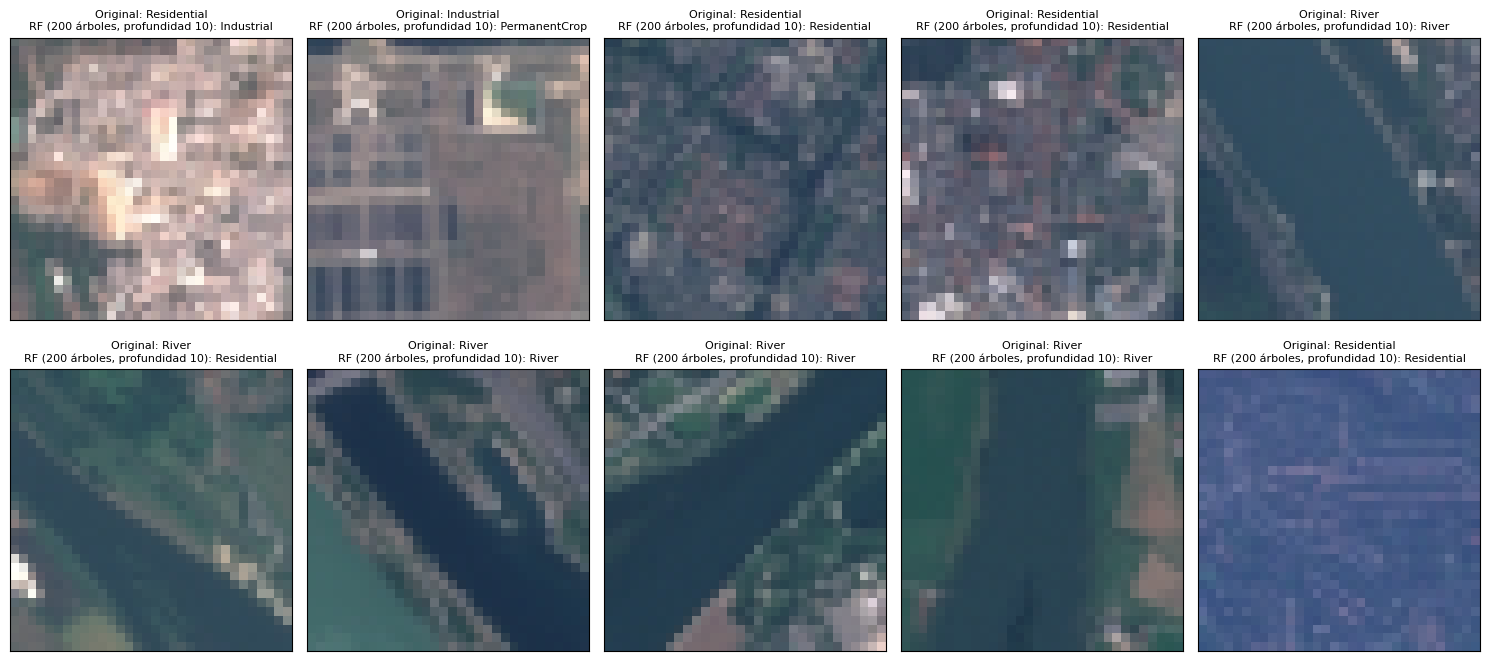

In [35]:
# Seleccionar 10 imágenes aleatorias
indices = np.random.choice(range(len(x_test)), size=10, replace=False)

# Crear una figura con 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Iterar sobre las 10 imágenes seleccionadas
for i, index in enumerate(indices):
    # Obtener la imagen y la etiqueta real
    image = x_test[index]
    true_label = y_test[index]

    # Predecir la etiqueta usando RandomForest con 200 árboles y profundidad 10
    predicted_label_rf_200_10 = clasificador_rf_200_10.predict([x_test_pca[index]])

    # Mostrar la imagen
    axes[i // 5, i % 5].imshow(image, cmap='gray')
    # Establecer el título con la etiqueta original y la predicción de Random Forest (200 árboles, profundidad 10)
    axes[i // 5, i % 5].set_title(f"Original: {true_label}\nRF (200 árboles, profundidad 10): {predicted_label_rf_200_10[0]}", fontsize=8)
    axes[i // 5, i % 5].set_xticks([])
    axes[i // 5, i % 5].set_yticks([])

# Mostrar la figura
plt.tight_layout()
plt.show()


4.2. Prueba 7 - 300 árboles y profundidad máxima de 20

Tiempo de entrenamiento (300 árboles, profundidad 20): 24.329004526138306
Precisión de Random Forest (300 árboles, profundidad 20): 0.8186666666666667

Informe de clasificación de Random Forest (300 árboles, profundidad 20):
               precision    recall  f1-score   support

       Forest       0.98      0.98      0.98       169
   Industrial       0.83      0.90      0.87       145
PermanentCrop       0.74      0.71      0.72       149
  Residential       0.76      0.73      0.74       140
        River       0.76      0.75      0.75       147

     accuracy                           0.82       750
    macro avg       0.81      0.81      0.81       750
 weighted avg       0.82      0.82      0.82       750


Matriz de confusión de Random Forest (300 árboles, profundidad 20):


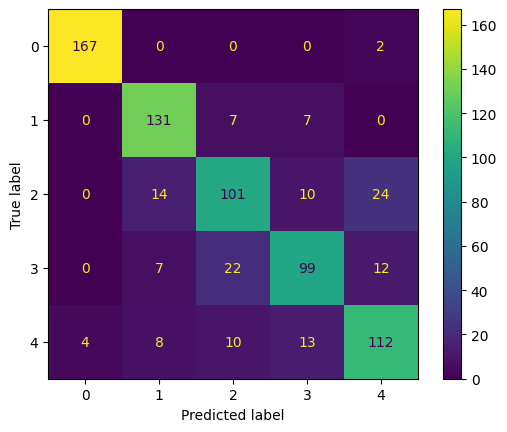

In [36]:
# Crear un clasificador de Random Forest con 300 árboles y profundidad máxima de 20
clasificador_rf_300_20 = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=20, random_state=0)

# Entrenar el clasificador con los datos de entrenamiento
start = time.time()
clasificador_rf_300_20.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento (300 árboles, profundidad 20): {end - start}")

# Realizar predicciones en los datos de prueba
y_pred_rf_300_20 = clasificador_rf_300_20.predict(x_test_pca)

# Comparación de desempeño
precision_rf_300_20 = accuracy_score(y_test, y_pred_rf_300_20)
print("Precisión de Random Forest (300 árboles, profundidad 20):", precision_rf_300_20)

# Informe de clasificación
print("\nInforme de clasificación de Random Forest (300 árboles, profundidad 20):")
print(classification_report(y_test, y_pred_rf_300_20))

# Matriz de confusión
print("\nMatriz de confusión de Random Forest (300 árboles, profundidad 20):")
cm_rf_300_20 = confusion_matrix(y_test, y_pred_rf_300_20)
disp_rf_300_20 = ConfusionMatrixDisplay(confusion_matrix=cm_rf_200_10)
disp_rf_300_20.plot()

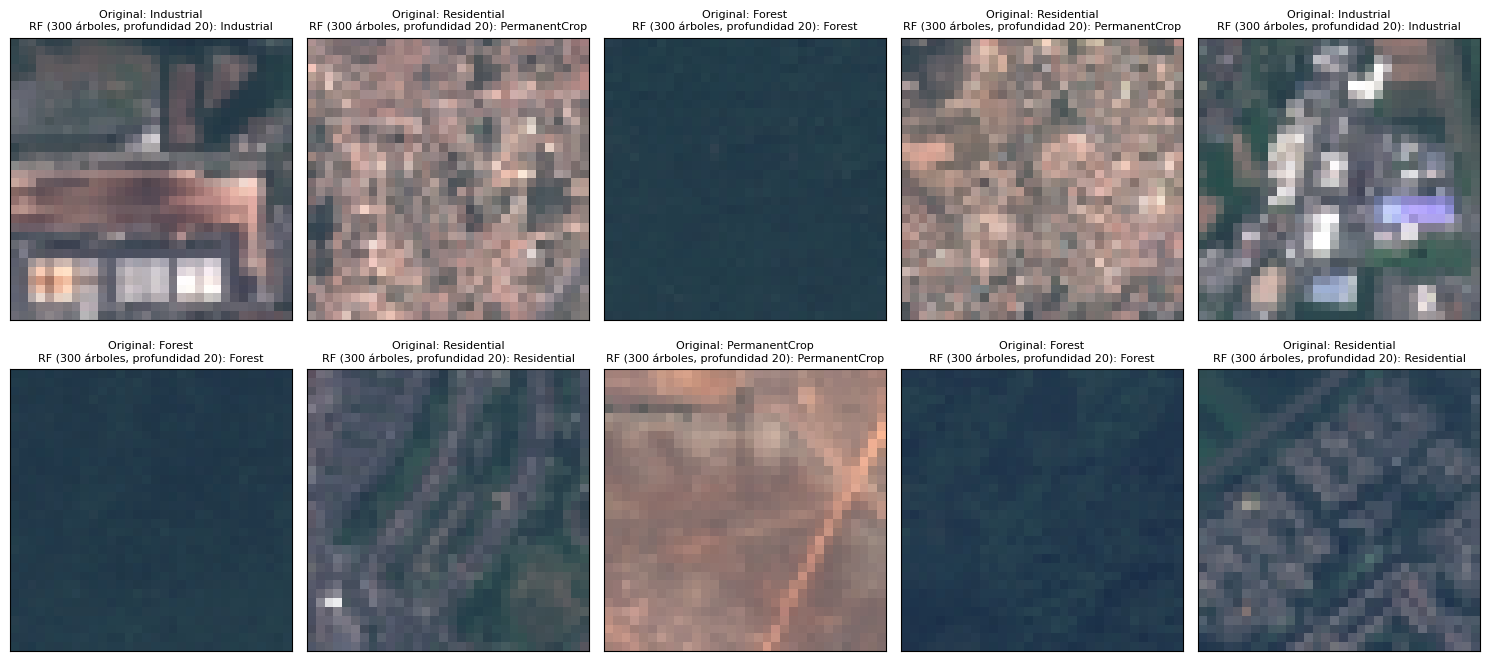

In [37]:
# Seleccionar 10 imágenes aleatorias
indices = np.random.choice(range(len(x_test)), size=10, replace=False)

# Crear una figura con 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Iterar sobre las 10 imágenes seleccionadas
for i, index in enumerate(indices):
    # Obtener la imagen y la etiqueta real
    image = x_test[index]
    true_label = y_test[index]

    # Predecir la etiqueta usando RandomForest con 300 árboles y profundidad 20
    predicted_label_rf_300_20 = clasificador_rf_300_20.predict([x_test_pca[index]])

    # Mostrar la imagen
    axes[i // 5, i % 5].imshow(image, cmap='gray')
    # Establecer el título con la etiqueta original y la predicción de Random Forest (300 árboles, profundidad 20)
    axes[i // 5, i % 5].set_title(f"Original: {true_label}\nRF (300 árboles, profundidad 20): {predicted_label_rf_300_20[0]}", fontsize=8)
    axes[i // 5, i % 5].set_xticks([])
    axes[i // 5, i % 5].set_yticks([])

# Mostrar la figura
plt.tight_layout()
plt.show()


Tiempo de búsqueda de hiperparámetros: 400.57858443260193
Mejores hiperparámetros: {'max_depth': 20, 'n_estimators': 300}
Precisión del mejor Random Forest: 0.82

Informe de clasificación del mejor Random Forest:
               precision    recall  f1-score   support

       Forest       0.98      0.98      0.98       169
   Industrial       0.83      0.91      0.87       145
PermanentCrop       0.73      0.69      0.71       149
  Residential       0.74      0.74      0.74       140
        River       0.79      0.76      0.77       147

     accuracy                           0.82       750
    macro avg       0.81      0.82      0.81       750
 weighted avg       0.82      0.82      0.82       750


Matriz de confusión del mejor Random Forest:


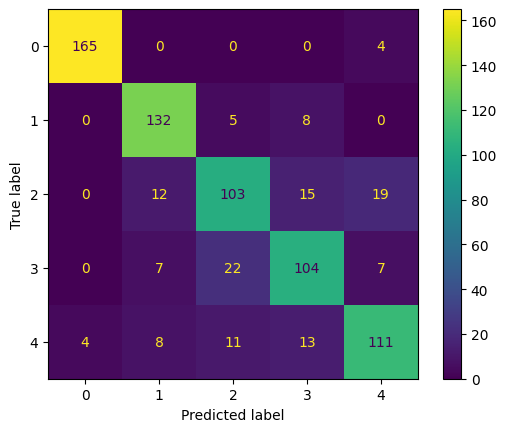

In [38]:
from sklearn.model_selection import GridSearchCV

clasificador_rf = RandomForestClassifier(random_state=0)

param_grid = {
    'n_estimators': [100, 120, 200, 300],  # Probamos diferentes números de árboles
    'max_depth': [2, 3, 5, 10, 20]  # Probamos diferentes profundidades máximas
}

# Inicializar GridSearchCV
grid_search_rf = GridSearchCV(clasificador_rf, param_grid, cv=5, scoring='accuracy')

# Entrenar GridSearchCV con los datos de entrenamiento
start = time.time()
grid_search_rf.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de búsqueda de hiperparámetros: {end - start}")

# Mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search_rf.best_params_)

# Realizamos predicciones en los datos de prueba usando el mejor modelo
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(x_test_pca)

# Comparación de desempeño del mejor modelo
precision_best_rf = accuracy_score(y_test, y_pred_best_rf)
print("Precisión del mejor Random Forest:", precision_best_rf)

# Informe de clasificación del mejor modelo
print("\nInforme de clasificación del mejor Random Forest:")
print(classification_report(y_test, y_pred_best_rf))

# Matriz de confusión del mejor modelo
print("\nMatriz de confusión del mejor Random Forest:")
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
disp_best_rf = ConfusionMatrixDisplay(confusion_matrix=cm_best_rf)
disp_best_rf.plot()

# Conclusiones:

1. Al hacer gradient boosting obtuvimos la mayor precisión del modelo, igual a  0.8306666666666667.
2. Implementamos Random Forest y al utilizar un valor estático de 100 árboles y una profundidad máxima predeterminada obtuvimos una presición de 0.8013333333333333.
3. Al ver que la presición era menor que con el método anterior, decidimos hacer pruebas con varios modelos a manera de Ensemble para aprender de los modelos Random Forest con cambios en los hiperparámetros. Según esto, la mejor presición fue con 300 árboles y una profundidad máxima de 20.
4. Finalmente, al hacer la busqueda de hiperparámetros a través del método Grid Search, confirmamos que la mejor presición de los modelos se conseguía con 300 árboles y profundidad máxima de 20 (según los modelos estudiados).